In [1]:
pip install ultralytics opencv-python mediapipe numpy


INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have proto

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


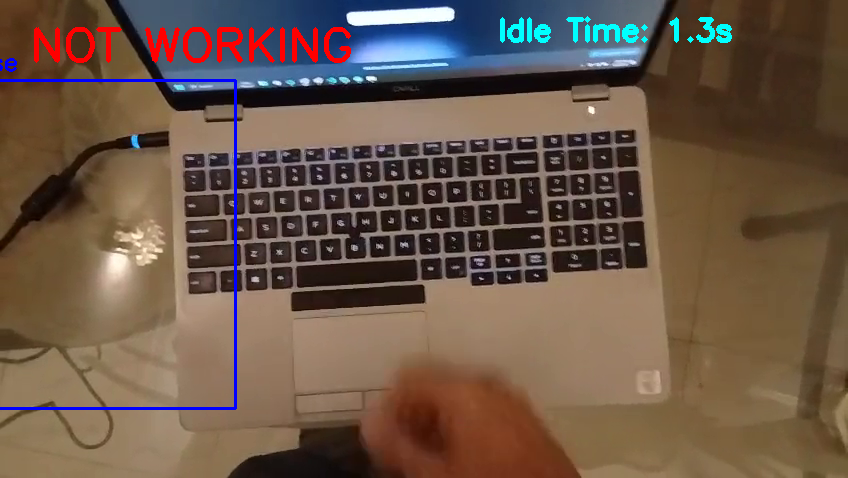

/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


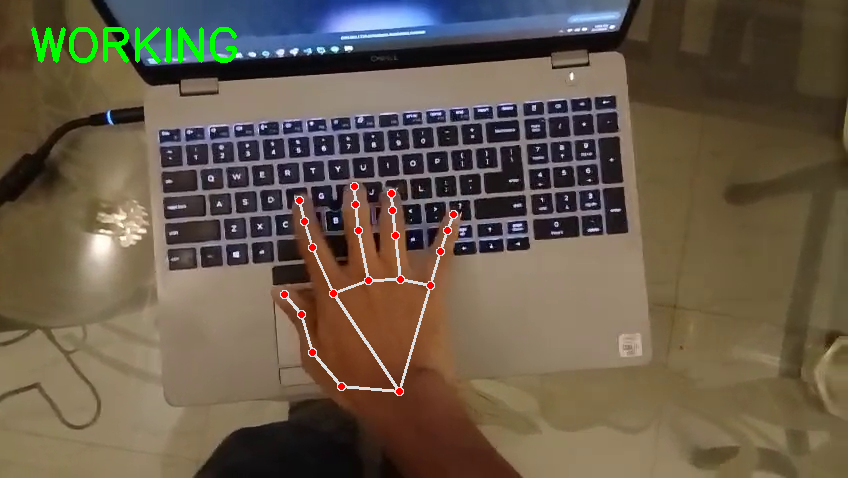

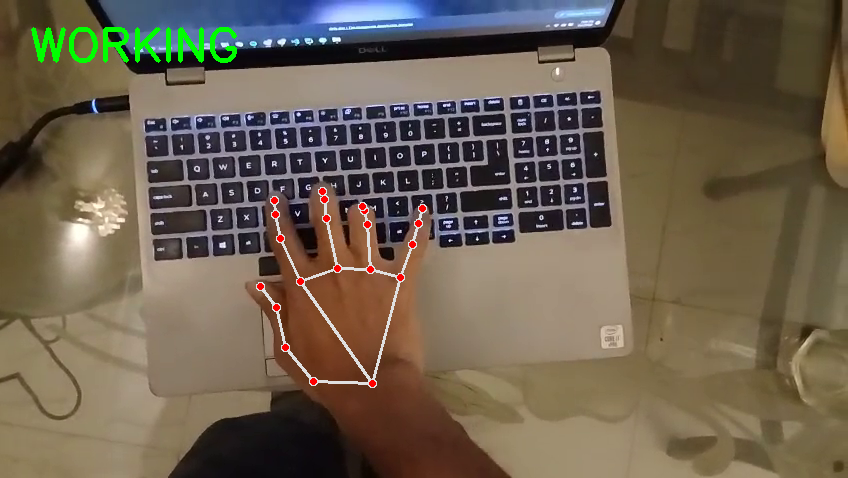

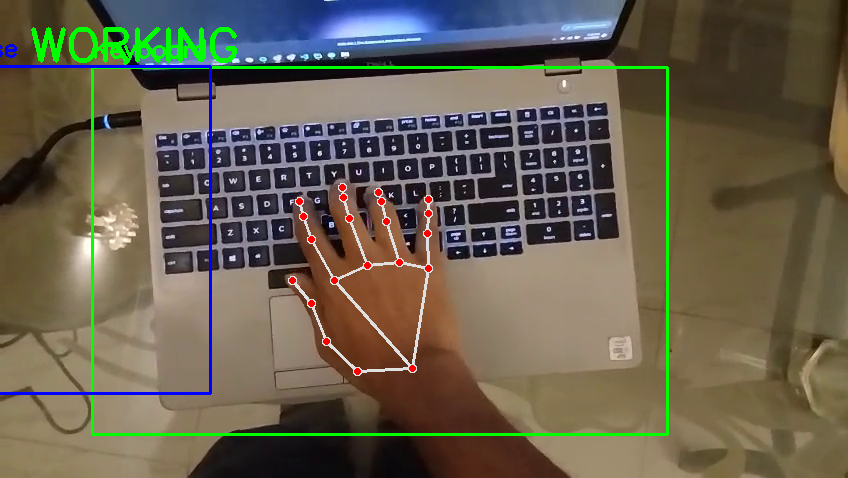

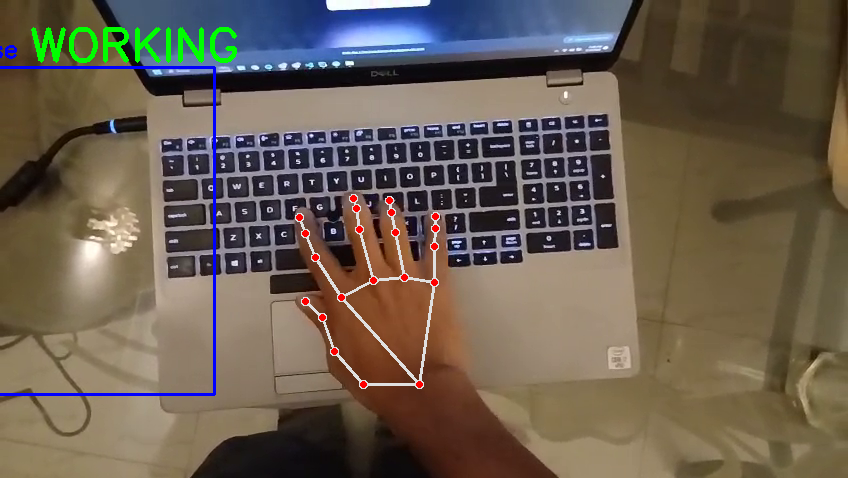

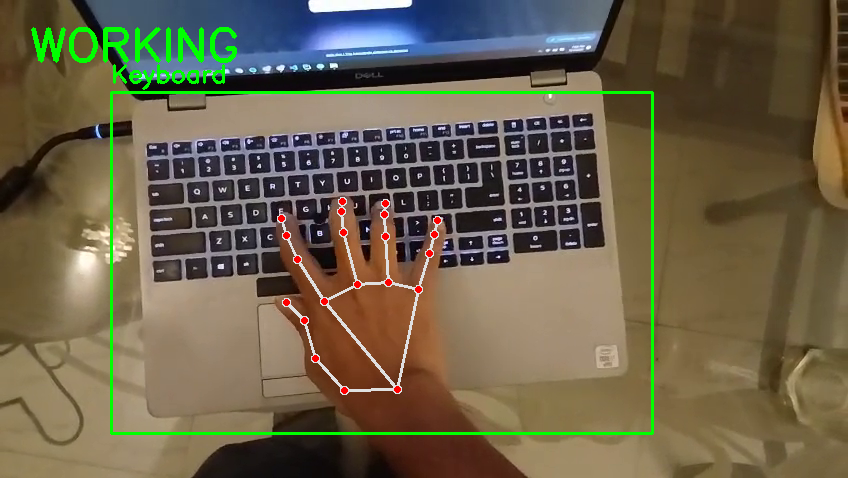

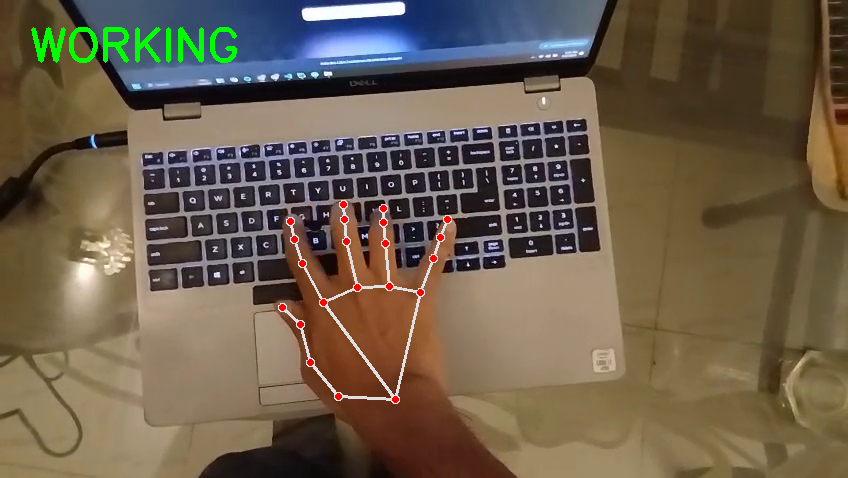

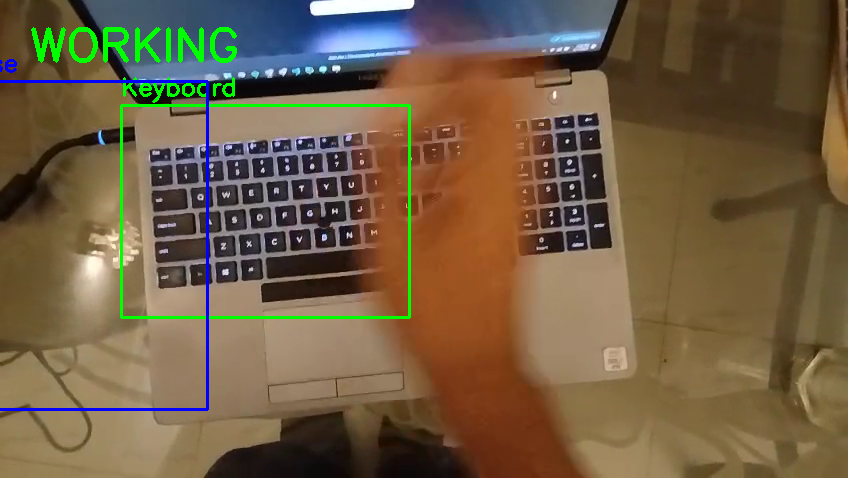

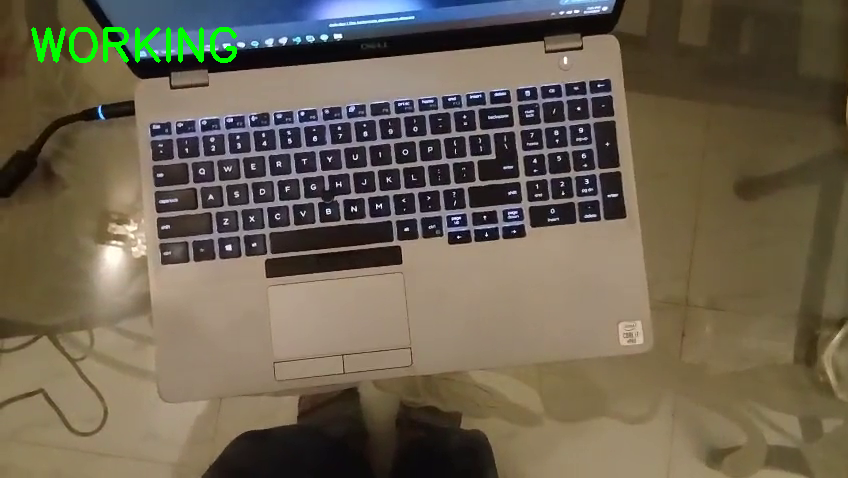

✅ Finished processing video.
✅ Stable Version Saved: /content/output_inference2.mp4


In [1]:
import cv2
from ultralytics import YOLO
import mediapipe as mp
import math
from google.colab.patches import cv2_imshow
import time

# Load YOLO
model = YOLO("yolo11s.pt")
allowed = ["keyboard", "mouse"]

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=2, min_detection_confidence=0.5)
mp_draw = mp.solutions.drawing_utils

input_video = "/content/WhatsApp Video 2025-11-01 at 7.20.36 PM.mp4"
cap = cv2.VideoCapture(input_video)

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
output_path = "/content/output_inference2.mp4"
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

prev_finger_positions = []
last_move_time = time.time()

working_frames = 0
idle_frames = 0                  # ✅ FPS-based counting
idle_time_seconds = 0

required_stable_frames = 8

final_state = False
frame_index = 0

def expand_box(box, margin):
    if box is None: return None
    x1, y1, x2, y2 = box
    return (x1 - margin, y1 - margin, x2 + margin, y2 + margin)

def inside(box, x, y):
    if box is None: return False
    x1, y1, x2, y2 = box
    return x1 <= x <= x2 and y1 <= y <= y2

while True:
    ret, frame = cap.read()
    if not ret:
        print("✅ Finished processing video.")
        break

    frame_index += 1
    h, w, _ = frame.shape
    keyboard_box = None
    mouse_box = None
    finger_centers = []

    # YOLO Detection
    results = model(frame, verbose=False)
    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            label = model.names[int(box.cls[0])].lower()

            if label not in allowed:
                continue

            if "keyboard" in label and keyboard_box is None:
                keyboard_box = expand_box((x1, y1, x2, y2), 25)

            if "mouse" in label and mouse_box is None:
                mouse_box = expand_box((x1, y1, x2, y2), 60)

    if keyboard_box:
        kx1, ky1, kx2, ky2 = keyboard_box
        cv2.rectangle(frame, (kx1, ky1), (kx2, ky2), (0, 255, 0), 2)
        cv2.putText(frame, "Keyboard", (kx1, ky1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    if mouse_box:
        mx1, my1, mx2, my2 = mouse_box
        cv2.rectangle(frame, (mx1, my1), (mx2, my2), (255, 0, 0), 2)
        cv2.putText(frame, "Mouse", (mx1, my1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)

    # Mediapipe Hands
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    hand_res = hands.process(rgb)

    if hand_res.multi_hand_landmarks:
        for hand in hand_res.multi_hand_landmarks:
            mp_draw.draw_landmarks(frame, hand, mp_hands.HAND_CONNECTIONS)

            for fid in [8,12,16,20]:
                fx = int(hand.landmark[fid].x * w)
                fy = int(hand.landmark[fid].y * h)
                finger_centers.append((fx, fy))

    # Movement detection
    moving = False
    if prev_finger_positions and finger_centers:
        for (cx, cy), (px, py) in zip(finger_centers, prev_finger_positions):
            if math.dist((cx, cy), (px, py)) > 1:
                moving = True
                last_move_time = time.time()
                break

    prev_finger_positions = finger_centers

    # Detect hands over device
    over_device = any(
        inside(keyboard_box, cx, cy) or inside(mouse_box, cx, cy)
        for (cx, cy) in finger_centers
    )

    # Frame counting
    if over_device and moving:
        working_frames += 1
        idle_frames = 0
        idle_time_seconds = 0
    else:
        working_frames = 0
        idle_frames += 1

    # Status switching after 1 second
    if working_frames > required_stable_frames:
        final_state = True
    if idle_frames > fps * 1:    # 1 second
        final_state = False

    # ✅ FPS-based idle time
    if final_state:
        idle_frames = 0
        idle_time_seconds = 0
    else:
        idle_time_seconds = idle_frames / fps

    # Display Status
    if final_state:
        cv2.putText(frame, "WORKING", (30, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 4)
    else:
        cv2.putText(frame, "NOT WORKING", (30, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 4)

        if idle_frames >= fps:   # show only after 1s
            cv2.putText(frame, f"Idle Time: {idle_time_seconds:.1f}s",
                        (w - 350, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 3)

    out.write(frame)

    if frame_index % 20 == 0:
        cv2_imshow(frame)

cap.release()
out.release()
print("✅ Stable Version Saved:", output_path)
